In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("CarPrice").getOrCreate()

In [3]:
df = spark.read.csv("Car details v3.csv",header=True,inferSchema=True)

In [4]:
df.show(1)

+--------------------+----+-------------+---------+------+-----------+------------+-----------+---------+-------+---------+--------------+-----+
|                name|year|selling_price|km_driven|  fuel|seller_type|transmission|      owner|  mileage| engine|max_power|        torque|seats|
+--------------------+----+-------------+---------+------+-----------+------------+-----------+---------+-------+---------+--------------+-----+
|Maruti Swift Dzir...|2014|       450000|   145500|Diesel| Individual|      Manual|First Owner|23.4 kmpl|1248 CC|   74 bhp|190Nm@ 2000rpm|    5|
+--------------------+----+-------------+---------+------+-----------+------------+-----------+---------+-------+---------+--------------+-----+
only showing top 1 row



In [5]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- selling_price: integer (nullable = true)
 |-- km_driven: integer (nullable = true)
 |-- fuel: string (nullable = true)
 |-- seller_type: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- owner: string (nullable = true)
 |-- mileage: string (nullable = true)
 |-- engine: string (nullable = true)
 |-- max_power: string (nullable = true)
 |-- torque: string (nullable = true)
 |-- seats: integer (nullable = true)



In [6]:
df = df.drop("name","torque")

In [7]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- selling_price: integer (nullable = true)
 |-- km_driven: integer (nullable = true)
 |-- fuel: string (nullable = true)
 |-- seller_type: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- owner: string (nullable = true)
 |-- mileage: string (nullable = true)
 |-- engine: string (nullable = true)
 |-- max_power: string (nullable = true)
 |-- seats: integer (nullable = true)



In [8]:
df.select("year","selling_price","km_driven","seats").describe().show()

+-------+------------------+-----------------+------------------+----------------+
|summary|              year|    selling_price|         km_driven|           seats|
+-------+------------------+-----------------+------------------+----------------+
|  count|              8128|             8128|              8128|            7907|
|   mean|2013.8040108267717|638271.8077017716| 69819.51082677166|5.41671936259011|
| stddev| 4.044248753683651|806253.4035082327|56550.554958219276|0.95958752023399|
|    min|              1983|            29999|                 1|               2|
|    max|              2020|         10000000|           2360457|              14|
+-------+------------------+-----------------+------------------+----------------+



In [9]:
# year
# km_driven
# fuel
# seller_type
# transmission
# owner
# mileage
# engine
# max_power
# seats

In [10]:
from pyspark.sql.functions import regexp_extract, col

# Extract numeric value from strings using regex
df = df.withColumn("mileage", regexp_extract(col("mileage"), r"([\d.]+)", 1).cast("float"))
df = df.withColumn("engine", regexp_extract(col("engine"), r"([\d.]+)", 1).cast("int"))
df = df.withColumn("max_power", regexp_extract(col("max_power"), r"([\d.]+)", 1).cast("float"))


In [11]:
df.show(1)

+----+-------------+---------+------+-----------+------------+-----------+-------+------+---------+-----+
|year|selling_price|km_driven|  fuel|seller_type|transmission|      owner|mileage|engine|max_power|seats|
+----+-------------+---------+------+-----------+------------+-----------+-------+------+---------+-----+
|2014|       450000|   145500|Diesel| Individual|      Manual|First Owner|   23.4|  1248|     74.0|    5|
+----+-------------+---------+------+-----------+------------+-----------+-------+------+---------+-----+
only showing top 1 row



In [12]:
df = df.withColumnRenamed("mileage", "mileage_kmpl") \
       .withColumnRenamed("engine", "engine_cc") \
       .withColumnRenamed("max_power", "max_power_bhp")


In [13]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- selling_price: integer (nullable = true)
 |-- km_driven: integer (nullable = true)
 |-- fuel: string (nullable = true)
 |-- seller_type: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- owner: string (nullable = true)
 |-- mileage_kmpl: float (nullable = true)
 |-- engine_cc: integer (nullable = true)
 |-- max_power_bhp: float (nullable = true)
 |-- seats: integer (nullable = true)



In [14]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+----+-------------+---------+----+-----------+------------+-----+------------+---------+-------------+-----+
|year|selling_price|km_driven|fuel|seller_type|transmission|owner|mileage_kmpl|engine_cc|max_power_bhp|seats|
+----+-------------+---------+----+-----------+------------+-----+------------+---------+-------------+-----+
|   0|            0|        0|   0|          0|           0|    0|         221|      221|          216|  221|
+----+-------------+---------+----+-----------+------------+-----+------------+---------+-------------+-----+



In [15]:
from pyspark.sql.types import IntegerType, FloatType, DoubleType

numeric_column_names = [column.name for column in df.schema.fields
                        if isinstance(column.dataType, (IntegerType, FloatType, DoubleType))]

In [16]:
from pyspark.ml.feature import Imputer

# Initialize the Imputer
imputer = Imputer(inputCols= ["mileage_kmpl","engine_cc","max_power_bhp","seats"], #specifying the input column names
    outputCols=["mileage_kmpl","engine_cc","max_power_bhp","seats"], #specifying the output column names
    strategy="mean"                  # or "median" if you want to use the median value
)
# Fit the Imputer
model = imputer.fit(df)

#Transform the dataset
df = model.transform(df)

In [17]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+----+-------------+---------+----+-----------+------------+-----+------------+---------+-------------+-----+
|year|selling_price|km_driven|fuel|seller_type|transmission|owner|mileage_kmpl|engine_cc|max_power_bhp|seats|
+----+-------------+---------+----+-----------+------------+-----+------------+---------+-------------+-----+
|   0|            0|        0|   0|          0|           0|    0|           0|        0|            0|    0|
+----+-------------+---------+----+-----------+------------+-----+------------+---------+-------------+-----+



In [18]:
df.select("fuel").distinct().show()
df.select("seller_type").distinct().show()
df.select("transmission").distinct().show()
df.select("owner").distinct().show()

+------+
|  fuel|
+------+
|Diesel|
|   CNG|
|   LPG|
|Petrol|
+------+

+----------------+
|     seller_type|
+----------------+
|      Individual|
|          Dealer|
|Trustmark Dealer|
+----------------+

+------------+
|transmission|
+------------+
|   Automatic|
|      Manual|
+------------+

+--------------------+
|               owner|
+--------------------+
|         Third Owner|
|Fourth & Above Owner|
|        Second Owner|
|         First Owner|
|      Test Drive Car|
+--------------------+



In [19]:
print("Number of rows:", df.count())
print("Number of columns:", len(df.columns))

Number of rows: 8128
Number of columns: 11


In [20]:
df = df.drop_duplicates()

In [21]:
print("Number of rows:", df.count())
print("Number of columns:", len(df.columns))

Number of rows: 6907
Number of columns: 11


In [22]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Categorical columns to encode
categorical_cols = ['fuel', 'seller_type', 'transmission', 'owner']
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in categorical_cols]

In [23]:
encoders

[OneHotEncoder_0d057ea7a87e,
 OneHotEncoder_84e3a7ea9ba5,
 OneHotEncoder_cfb14a38bb98,
 OneHotEncoder_05a708fc467c]

In [24]:
from pyspark.ml.feature import VectorAssembler

# Numerical + encoded categorical columns
numerical_cols = ['year', 'km_driven', 'mileage_kmpl', 'engine_cc', 'max_power_bhp', 'seats']
assembler_inputs = [col+"_encoded" for col in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")

In [25]:
assembler

VectorAssembler_fc92f3351d16

In [26]:
pipeline = Pipeline(stages=indexers + encoders + [assembler])
pipeline_model = pipeline.fit(df)
df = pipeline_model.transform(df)

# Show the final features and target column
df.select("features", "selling_price").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------+-------------+
|features                                                                                                |selling_price|
+--------------------------------------------------------------------------------------------------------+-------------+
|(16,[0,4,6,10,11,12,13,14,15],[1.0,1.0,1.0,2017.0,47000.0,13.5,2987.0,282.0,5.0])                       |5850000      |
|[1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2009.0,70000.0,13.600000381469727,2523.0,63.0,8.0]             |270000       |
|[0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2019.0,20000.0,18.899999618530273,1197.0,81.86000061035156,5.0]|600000       |
|[0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2019.0,30000.0,18.600000381469727,1197.0,81.86000061035156,5.0]|750000       |
|[1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2005.0,80000.0,13.600000381469727,2523.0,63.0,7.0]             |250000       |
+-------------------------------

In [27]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- selling_price: integer (nullable = true)
 |-- km_driven: integer (nullable = true)
 |-- fuel: string (nullable = true)
 |-- seller_type: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- owner: string (nullable = true)
 |-- mileage_kmpl: float (nullable = true)
 |-- engine_cc: integer (nullable = true)
 |-- max_power_bhp: float (nullable = true)
 |-- seats: integer (nullable = true)
 |-- fuel_index: double (nullable = false)
 |-- seller_type_index: double (nullable = false)
 |-- transmission_index: double (nullable = false)
 |-- owner_index: double (nullable = false)
 |-- fuel_encoded: vector (nullable = true)
 |-- seller_type_encoded: vector (nullable = true)
 |-- transmission_encoded: vector (nullable = true)
 |-- owner_encoded: vector (nullable = true)
 |-- features: vector (nullable = true)



In [28]:
print("Number of rows:", df.count())
print("Number of columns:", len(df.columns))

Number of rows: 6907
Number of columns: 20


In [29]:
#numeric_features = ["year", "km_driven", "mileage_kmpl", "engine_cc", "max_power_bhp", "seats"]
#pandas_df = df.select(numeric_features).toPandas()

In [30]:
#import seaborn as sns
#import matplotlib.pyplot as plt

#corr = pandas_df.corr()

#plt.figure(figsize=(8,6))
#sns.heatmap(corr, annot=True, cmap="coolwarm")
#plt.title("Correlation Matrix")
#plt.show()

In [31]:
#sns.pairplot(data=pandas_df)
#plt.show()

In [32]:
from pyspark.ml.regression import LinearRegression

In [33]:
lr = LinearRegression(featuresCol="features", labelCol="selling_price")

In [34]:
model_lr = lr.fit(df)

In [35]:
predictions_lr = model_lr.transform(df)
predictions_lr.select("features", "selling_price", "prediction").show(5)

+--------------------+-------------+------------------+
|            features|selling_price|        prediction|
+--------------------+-------------+------------------+
|(16,[0,4,6,10,11,...|      5850000|2787380.3158815354|
|[1.0,0.0,0.0,1.0,...|       270000| 168632.9874541387|
|[0.0,1.0,0.0,1.0,...|       600000| 615145.6169371903|
|[0.0,1.0,0.0,1.0,...|       750000| 607469.9634507522|
|[1.0,0.0,0.0,1.0,...|       250000| 91037.44441560656|
+--------------------+-------------+------------------+
only showing top 5 rows



In [36]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="selling_price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_lr)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 311480.1698597603


In [37]:
from pyspark.ml.regression import DecisionTreeRegressor

In [38]:
dt = DecisionTreeRegressor(featuresCol="features", labelCol="selling_price",maxDepth=23)

In [39]:
model_dt = dt.fit(df)
predictions_dt = model_dt.transform(df)
predictions_dt.select("features", "selling_price", "prediction").show(5)


+--------------------+-------------+----------+
|            features|selling_price|prediction|
+--------------------+-------------+----------+
|(16,[0,4,6,10,11,...|      5850000| 5850000.0|
|[1.0,0.0,0.0,1.0,...|       270000|  270000.0|
|[0.0,1.0,0.0,1.0,...|       600000|  600000.0|
|[0.0,1.0,0.0,1.0,...|       750000|  750000.0|
|[1.0,0.0,0.0,1.0,...|       250000|  250000.0|
+--------------------+-------------+----------+
only showing top 5 rows



In [40]:
evaluator_dt = RegressionEvaluator(labelCol="selling_price", predictionCol="prediction", metricName="rmse")
rmse_dt = evaluator_dt.evaluate(predictions_dt)
print(f"Root Mean Squared Error (RMSE): {rmse_dt}")

Root Mean Squared Error (RMSE): 26390.534861540946


In [41]:
from pyspark.ml.regression import RandomForestRegressor

In [42]:
rf = RandomForestRegressor(featuresCol="features", labelCol="selling_price",maxDepth=9)

In [43]:
model_rf = rf.fit(df)
predictions_rf = model_rf.transform(df)
predictions_rf.select("features", "selling_price", "prediction").show(5)


+--------------------+-------------+------------------+
|            features|selling_price|        prediction|
+--------------------+-------------+------------------+
|(16,[0,4,6,10,11,...|      5850000|4046510.8677776335|
|[1.0,0.0,0.0,1.0,...|       270000| 293955.5537739893|
|[0.0,1.0,0.0,1.0,...|       600000| 584316.4407415693|
|[0.0,1.0,0.0,1.0,...|       750000| 582807.1391339686|
|[1.0,0.0,0.0,1.0,...|       250000|247591.65183357825|
+--------------------+-------------+------------------+
only showing top 5 rows



In [44]:
evaluator_rf = RegressionEvaluator(labelCol="selling_price", predictionCol="prediction", metricName="rmse")
rmse_rf = evaluator_rf.evaluate(predictions_rf)
print(f"Root Mean Squared Error (RMSE): {rmse_rf}")

Root Mean Squared Error (RMSE): 130727.79767947654


In [45]:
from pyspark.ml.regression import GBTRegressor

In [46]:
gbt = GBTRegressor(featuresCol="features", labelCol="selling_price", maxDepth=19)

In [47]:
model_gbt = gbt.fit(df)
predictions_gbt = model_gbt.transform(df)
predictions_gbt.select("features", "selling_price", "prediction").show(5)


+--------------------+-------------+------------------+
|            features|selling_price|        prediction|
+--------------------+-------------+------------------+
|(16,[0,4,6,10,11,...|      5850000| 5850000.059021673|
|[1.0,0.0,0.0,1.0,...|       270000| 269997.7650787173|
|[0.0,1.0,0.0,1.0,...|       600000| 600058.2042816209|
|[0.0,1.0,0.0,1.0,...|       750000| 750031.7346876716|
|[1.0,0.0,0.0,1.0,...|       250000|250002.66085676974|
+--------------------+-------------+------------------+
only showing top 5 rows



In [48]:
evaluator_gbt = RegressionEvaluator(labelCol="selling_price", predictionCol="prediction", metricName="rmse")
rmse_gbt = evaluator_gbt.evaluate(predictions_gbt)
print(f"Root Mean Squared Error (RMSE): {rmse_gbt}")

Root Mean Squared Error (RMSE): 26029.69736352462


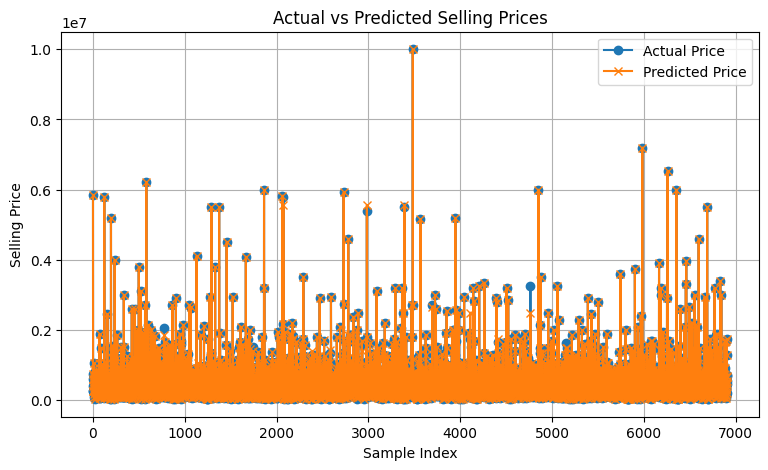

In [50]:
comparison_df = predictions_gbt.select("selling_price", "prediction")
# Convert to Pandas for visualization
pandas_comparison_df = comparison_df.toPandas()

import matplotlib.pyplot as plt

# Plot actual vs predicted prices
plt.figure(figsize=(9,5))
plt.plot(pandas_comparison_df['selling_price'], label='Actual Price', marker='o')
plt.plot(pandas_comparison_df['prediction'], label='Predicted Price', marker='x')
plt.title('Actual vs Predicted Selling Prices')
plt.xlabel('Sample Index')
plt.ylabel('Selling Price')
plt.legend()
plt.grid(True)
plt.show()
